In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import tensorflow as tf
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import plotly.express as px
import statistics
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(15,5)})

In [3]:
normal = pd.read_csv('normal.csv')
ssp2_10_40 = pd.read_csv('ssp2_10_41.csv')
ssp2_41_70 = pd.read_csv('ssp2_41_70.csv')
ssp5_10_40 = pd.read_csv('ssp5_11_40.csv')
ssp5_41_70 = pd.read_csv('ssp5_41_70.csv')
dataframes = [normal, ssp2_10_40, ssp2_41_70, ssp5_10_40, ssp5_41_70]

# Pre-processing

In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_dataframes = []
for df in dataframes:
  data = pd.DataFrame(scaler.fit_transform(df))
  data.columns = df.columns
  scaled_dataframes.append(data)

In [80]:
def get_x_y(df):
    wind_x = df[df.capacity_f.notna()].iloc[:,13:].dropna()
    wind_y = df.loc[wind_x.index,'capacity_f']
    solar_x = df[df.pv_capacit.notna()].iloc[:,13:].dropna()
    solar_y = df.loc[solar_x.index,'pv_capacit']
    wind_df = df.iloc[wind_x.index,:]
    solar_df = df.iloc[solar_x.index,:]
    return wind_x, wind_y, solar_x, solar_y, wind_df, solar_df

In [81]:
def prep_data(df, wind_or_solar):
  wind_x, wind_y, solar_x, solar_y, wind_df, solar_df = get_x_y(df)
  if wind_or_solar=='solar':
    X_train, X_test, y_train, y_test = train_test_split(solar_x,solar_y,random_state=42)
  else: 
    X_train, X_test, y_train, y_test = train_test_split(wind_x,wind_y,random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=42) 
  return X_train, X_test, y_train, y_test, X_val, y_val



# Finding the Most Accurate DNN Model for Solar Normal data

#### Data and Function Prep for DNN

In [160]:
# X_train, X_test, y_train, y_test, X_val, y_val = prep_data(scaled_dataframes[0], 'solar')
EPOCHS = 100
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

def history_plot(model_history,title,saveas):
    plot = pd.DataFrame(model_history.history).plot(figsize=(15, 5)) 
    plt.grid(True)
    plt.gca()#.set_ylim(0, topylim)
    plt.title(title)
    plt.show()
    fig = plot.get_figure()
    fig.savefig(f"{saveas}_history.png", width=600, height=200)

def to_graph_df(model, wind_or_solar):
    train_predict = pd.DataFrame(model.predict(X_train))#.rename({0:'predicted_train'},axis=1)
    train_predict['predict_type'] = 'train'
    test_predict = pd.DataFrame(model.predict(X_test))#.rename({0:'predicted_test'},axis=1)
    test_predict['predict_type'] = 'test'
    val_predict = pd.DataFrame(model.predict(X_val))#.rename({0:'predicted_validation'},axis=1)
    val_predict['predict_type'] = 'val'
    actual_data = pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_val),pd.DataFrame(y_test)],axis=0)
    train_predict.index = X_train.index
    test_predict.index = X_test.index
    val_predict.index = X_val.index
    predicted_data = pd.concat([train_predict,test_predict,val_predict],axis=0)
    modeldata = predicted_data.merge(actual_data,left_index=True,right_index=True).rename({0:'predicted_y'},axis=1)
    return modeldata
def get_mse_corr(result_df,predict_type,outcome_variable):
  sub_df = result_df[result_df.predict_type==predict_type]
  mse = mean_squared_error(sub_df[outcome_variable], sub_df.predicted_y)
  corr = pearsonr(sub_df[outcome_variable], sub_df.predicted_y)

  return mse, corr

def get_compiled_results(model,history,title,model_name,wind_or_solar,saveas):
  if wind_or_solar == 'solar':
    y_var = 'pv_capacit'
    y_label = 'Predicted PV Capacity Factor '
    y_label2 = 'Actual PV Capacity Factor'
    x_label = 'PV Capacity Factor'
  else:
    y_var = 'capacity_f'
    y_label = 'Predicted Wind Capacity Factor'
    y_label2 = 'Actual Wind Capacity Factor'
    x_label = 'Wind Capacity Factor'
  history_plot(history,title,saveas)
  result = to_graph_df(model,wind_or_solar)


  loop_results = ['train','test','val']
  fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,3.5))
  for i in loop_results:
    a = result[result.predict_type==i]
    b = pd.DataFrame(a[y_var]).rename({y_var:'predicted_y'},axis=1)
    b['predict_type'] = 'actual y'

    boxplot_df = pd.concat([a[['predicted_y','predict_type']],b]).rename({'predicted_y': x_label},axis=1)
    if i == 'train':
      axes = ax1
    elif i =='test':
      axes=ax2
    else: axes =ax3
    h = sns.boxplot(data=boxplot_df, x=x_label, y='predict_type',ax=axes).set(ylabel=None)
  fig.savefig(f"{saveas}_boxplot.png", width=600, height=200)


  g = sns.lmplot(data=result,x='predicted_y',y=y_var,scatter_kws={'alpha':0.5},
                 col="predict_type", height=3,
                facet_kws=dict(sharex=False, sharey=True),
            )
  g.fig.set_size_inches(15,4)
  g.set(xlabel='Model Predicted Y', ylabel=y_label2)
  plt.savefig(f"{saveas}_three_plots.png", width=600, height=200)

  loop_results = ['train','test','val']
  for i,v in enumerate(loop_results):
    error_val, corr = get_mse_corr(result,v,y_var)
    print(f"{model_name} {v} outcome has {round(error_val,5)} MSE and the predicted data has {round(corr[0]*100,2)}& correlation at {corr[1]} p-level with the actual data.")

def get_model_results1(model,model_history,wind_or_solar):
  model_results = []
  if wind_or_solar == 'solar':
    y_var = 'pv_capacit'
  else:
    y_var = 'capacity_f'
  loop_results = ['train','test','val']
  result = to_graph_df(model,wind_or_solar)
  for i,v in enumerate(loop_results):
    error_val, corr = get_mse_corr(result,v,y_var)
    model_results.append(error_val)
    model_results.append(round(corr[0]*100,2))
  model_results.append(statistics.variance(model_history.history['loss']))
  model_results.append(statistics.variance(model_history.history['val_loss']))
  model_results.append(round((model_history.history['loss'][-1] - model_history.history['loss'][0])/len(model_history.history['loss']),7))
  model_results.append(round((model_history.history['val_loss'][-1] - model_history.history['val_loss'][0])/len(model_history.history['val_loss']),7))

  columns = ['Train MSE','Train Corr', 'Test MSE','Test Corr','Validation MSE','Validation Corr','Train Loss Variance','Validation Loss Variance','Rate of Change in Train Loss','Rate of Change in Validation Loss']
  result_summary = pd.DataFrame(model_results).T
  result_summary.columns = columns
  return result_summary

## DNN Model 1 - Simple DNN with Early Stopping
 If the loss curve flattens at a high value early, the learning rate is probably low. If the loss curve follows a zigzag pattern, the learning rate is too high.

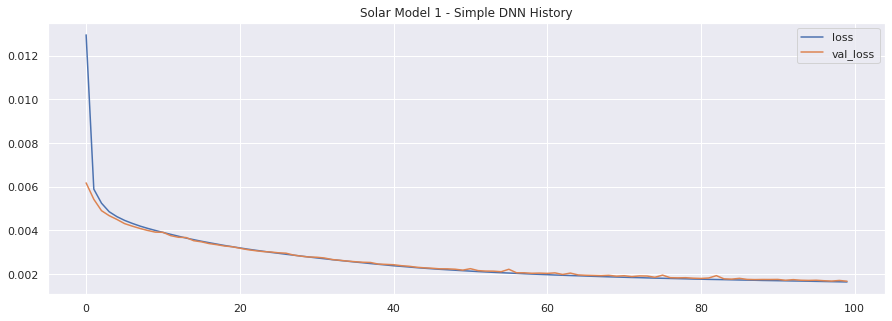

617/617 [==============================] - 1s 1ms/step
SModel1_1 train outcome has 0.00137 MSE and the predicted data has 97.79& correlation at 0.0 p-level with the actual data.
SModel1_1 test outcome has 0.00147 MSE and the predicted data has 97.66& correlation at 0.0 p-level with the actual data.
SModel1_1 val outcome has 0.00139 MSE and the predicted data has 97.73& correlation at 0.0 p-level with the actual data.


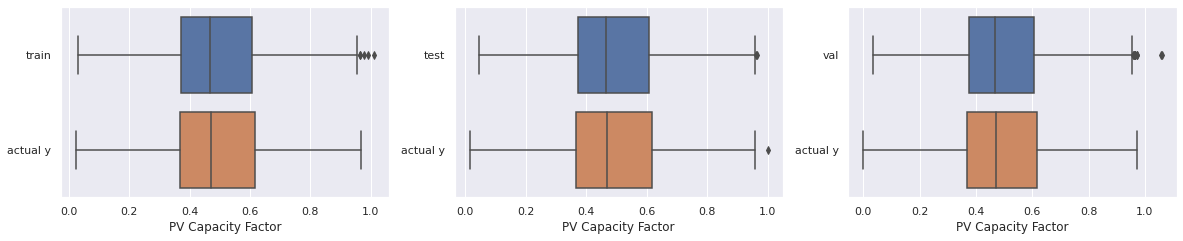

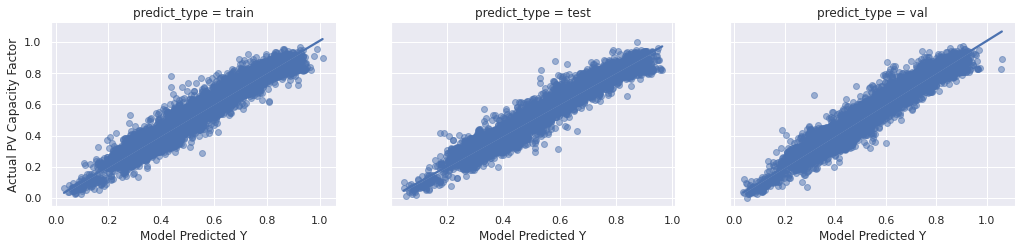

In [53]:
smodel1_1 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(1)
     ])
smodel1_1.compile(loss="mean_squared_error", optimizer="sgd")

history1_1 = smodel1_1.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_1,history1_1,'Solar Model 1 - Simple DNN History','SModel1_1','solar','solar_model12')

## DNN Model 2 - Simple DNN with SELU and Early Stopping



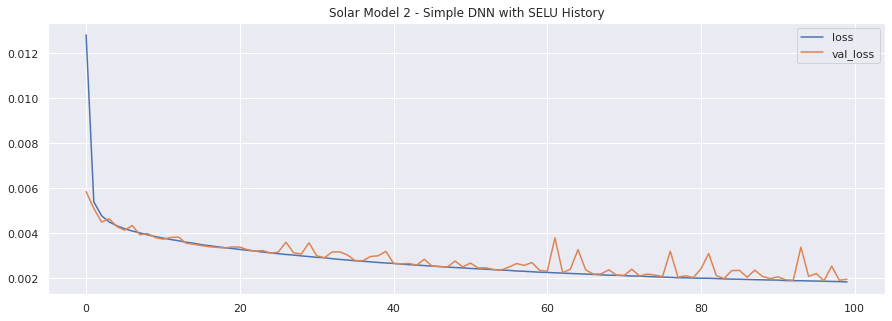

617/617 [==============================] - 2s 3ms/step
SModel1_2 train outcome has 0.00192 MSE and the predicted data has 97.07& correlation at 0.0 p-level with the actual data.
SModel1_2 test outcome has 0.00199 MSE and the predicted data has 96.99& correlation at 0.0 p-level with the actual data.
SModel1_2 val outcome has 0.00195 MSE and the predicted data has 96.98& correlation at 0.0 p-level with the actual data.


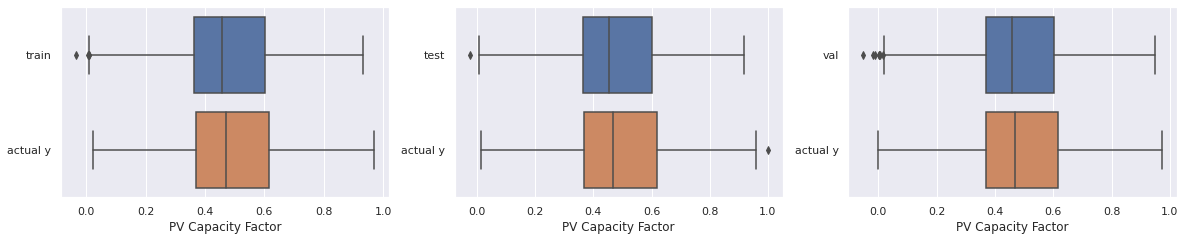

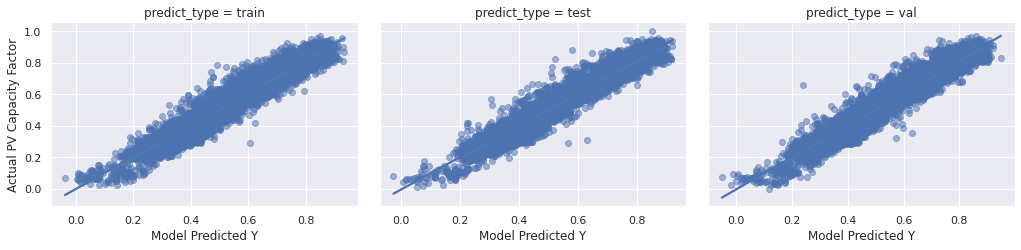

In [54]:
initializer = tf.keras.initializers.LecunNormal()

smodel1_2 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="selu", input_shape=X_train.shape[1:],kernel_initializer=initializer),
         tf.keras.layers.Dense(1)
     ])
smodel1_2.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_2 = smodel1_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_2,shistory1_2,'Solar Model 2 - Simple DNN with SELU History','SModel1_2','solar','solar_model22')

## DNN Model 3 - Simple Model with DNN ADAM


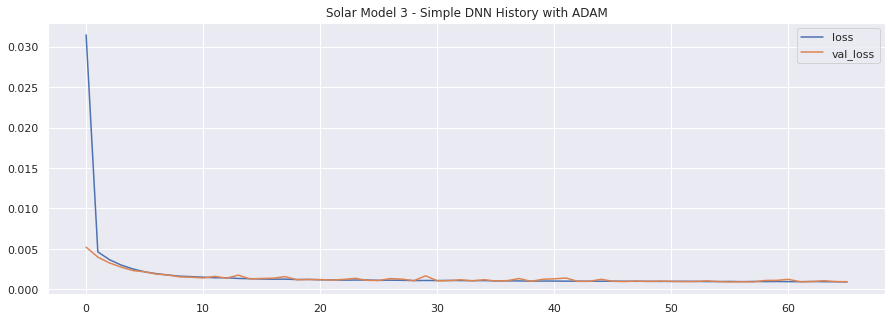

617/617 [==============================] - 1s 1ms/step
SModel1_3 train outcome has 0.00088 MSE and the predicted data has 98.57& correlation at 0.0 p-level with the actual data.
SModel1_3 test outcome has 0.00095 MSE and the predicted data has 98.48& correlation at 0.0 p-level with the actual data.
SModel1_3 val outcome has 0.00092 MSE and the predicted data has 98.5& correlation at 0.0 p-level with the actual data.


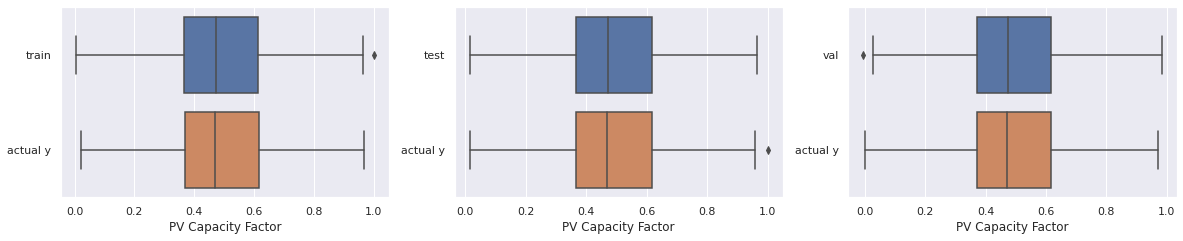

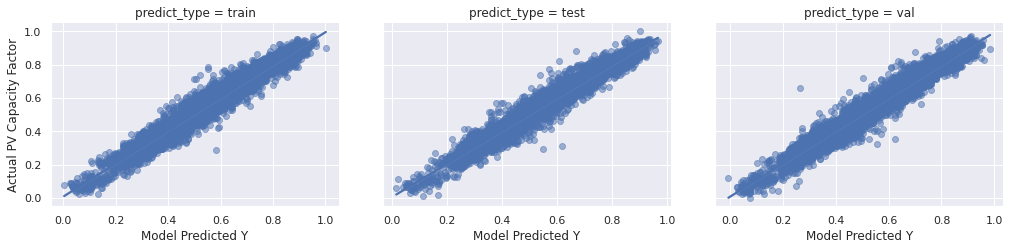

In [88]:
smodel1_3 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(1)
     ])
smodel1_3.compile(loss="mean_squared_error", optimizer="adam")

shistory1_3 = smodel1_3.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_3,shistory1_3,'Solar Model 3 - Simple DNN History with ADAM','SModel1_3','solar','solar_model32')

## DNN Model 4 - Multilayer Model

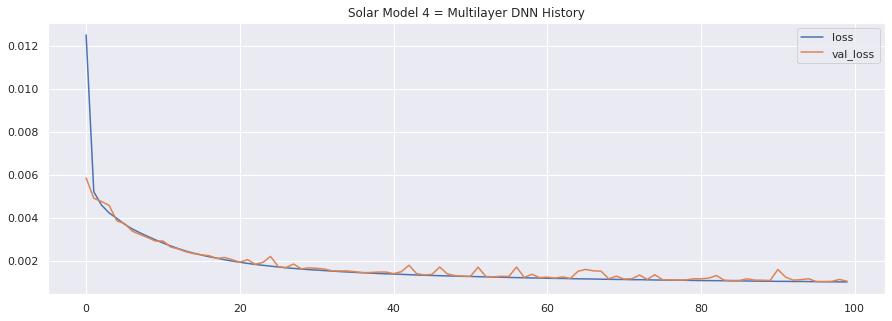

617/617 [==============================] - 1s 2ms/step
SModel1_4 train outcome has 0.00103 MSE and the predicted data has 98.4& correlation at 0.0 p-level with the actual data.
SModel1_4 test outcome has 0.0011 MSE and the predicted data has 98.3& correlation at 0.0 p-level with the actual data.
SModel1_4 val outcome has 0.00104 MSE and the predicted data has 98.36& correlation at 0.0 p-level with the actual data.


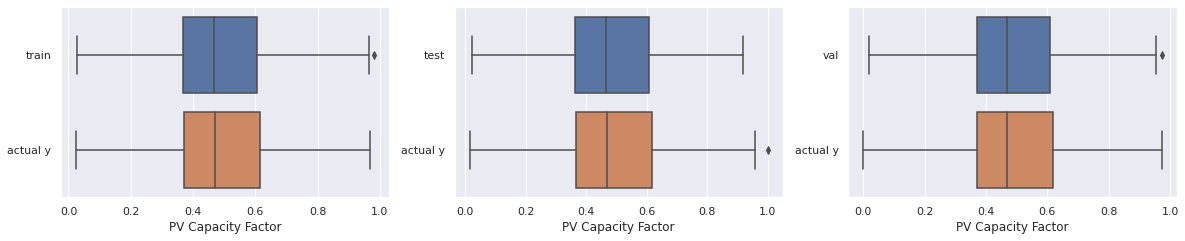

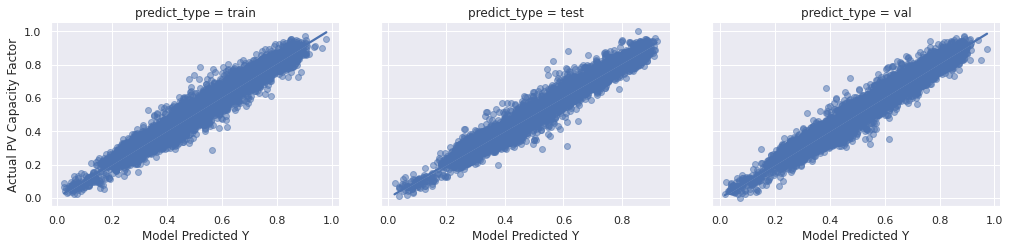

In [56]:
smodel1_4 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dense(1)
     ])
smodel1_4.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_4 = smodel1_4.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_4,shistory1_4,'Solar Model 4 = Multilayer DNN History','SModel1_4','solar','solar_model42')

## DNN Model 4.2 - Multilayer Model with Adam

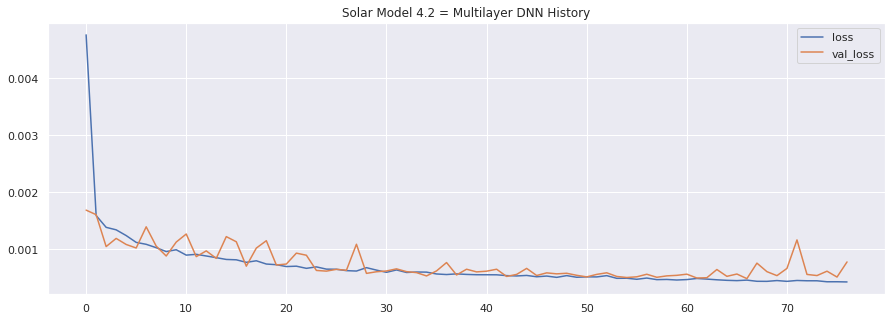

617/617 [==============================] - 1s 2ms/step
SModel1_4_2 train outcome has 0.00039 MSE and the predicted data has 99.39& correlation at 0.0 p-level with the actual data.
SModel1_4_2 test outcome has 0.0005 MSE and the predicted data has 99.23& correlation at 0.0 p-level with the actual data.
SModel1_4_2 val outcome has 0.00048 MSE and the predicted data has 99.23& correlation at 0.0 p-level with the actual data.


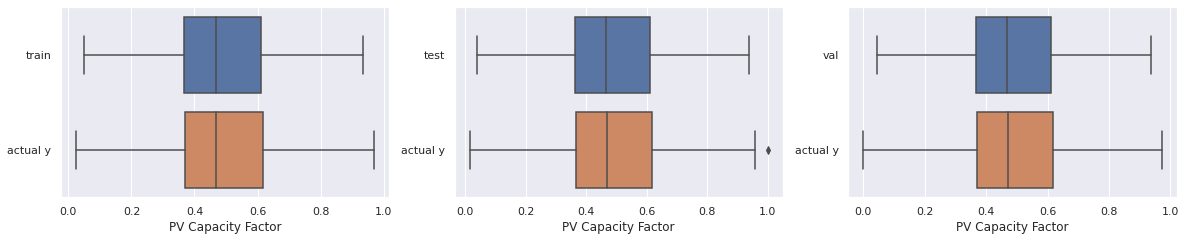

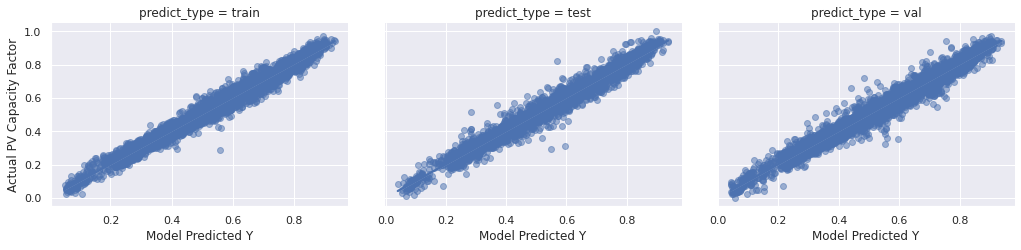

In [91]:
smodel1_4_2 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dense(1)
     ])
smodel1_4_2.compile(loss="mean_squared_error", optimizer="adam")

shistory1_4_2 = smodel1_4_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_4_2,shistory1_4_2,'Solar Model 4.2 = Multilayer DNN History','SModel1_4_2','solar','solar_model42_2')

## DNN Model 5 - Multilayer Model with Batch Normalization

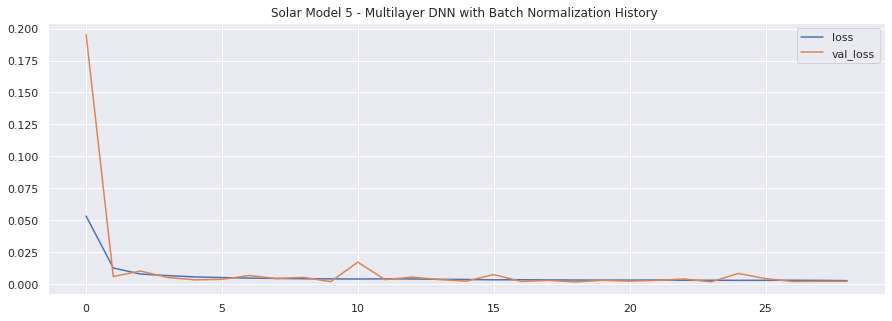

617/617 [==============================] - 1s 2ms/step
SModel1_5 train outcome has 0.00158 MSE and the predicted data has 97.58& correlation at 0.0 p-level with the actual data.
SModel1_5 test outcome has 0.00166 MSE and the predicted data has 97.5& correlation at 0.0 p-level with the actual data.
SModel1_5 val outcome has 0.00162 MSE and the predicted data has 97.51& correlation at 0.0 p-level with the actual data.


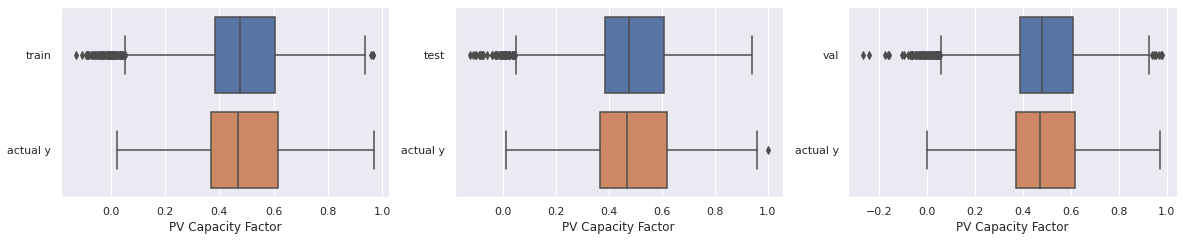

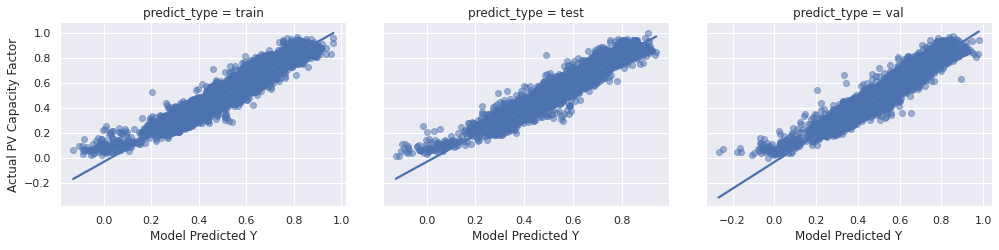

In [57]:
smodel1_5 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_5.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_5 = smodel1_5.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_5,shistory1_5,'Solar Model 5 - Multilayer DNN with Batch Normalization History ','SModel1_5','solar','solar_model52')

## DNN Model 5.2 - Multilayer Model with Batch Normalization and Adam

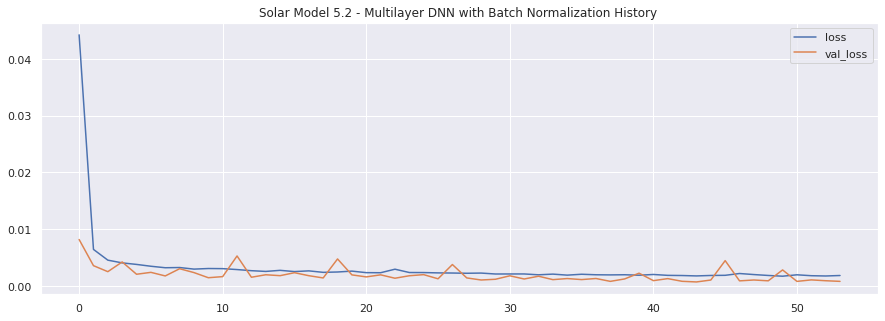

617/617 [==============================] - 1s 2ms/step
SModel1_5_2 train outcome has 0.00064 MSE and the predicted data has 99.01& correlation at 0.0 p-level with the actual data.
SModel1_5_2 test outcome has 0.00071 MSE and the predicted data has 98.91& correlation at 0.0 p-level with the actual data.
SModel1_5_2 val outcome has 0.00069 MSE and the predicted data has 98.93& correlation at 0.0 p-level with the actual data.


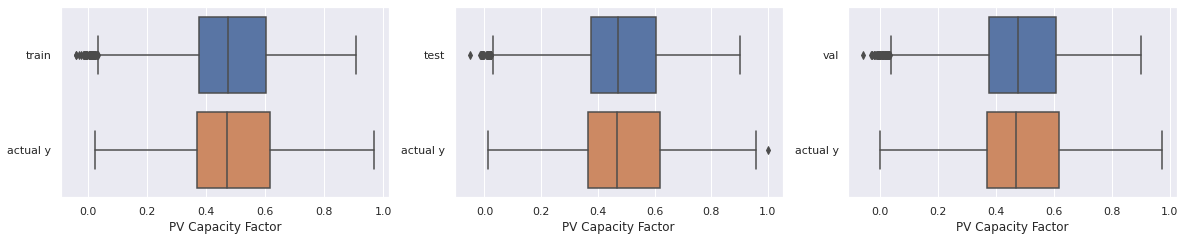

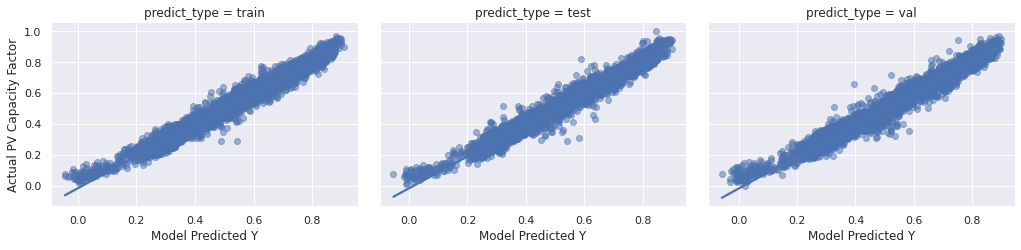

In [93]:
smodel1_5_2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_5_2.compile(loss="mean_squared_error", optimizer="adam")

shistory1_5_2 = smodel1_5_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_5_2,shistory1_5_2,'Solar Model 5.2 - Multilayer DNN with Batch Normalization History ','SModel1_5_2','solar','solar_model52_2')

## DNN Model 6 - Multilayer Model with Batch Normalization and Dropout

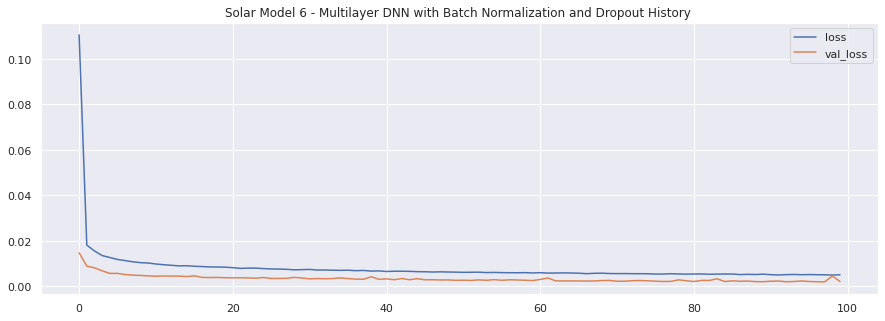

617/617 [==============================] - 1s 2ms/step
SModel1_6 train outcome has 0.00204 MSE and the predicted data has 97.03& correlation at 0.0 p-level with the actual data.
SModel1_6 test outcome has 0.00218 MSE and the predicted data has 96.87& correlation at 0.0 p-level with the actual data.
SModel1_6 val outcome has 0.00212 MSE and the predicted data has 96.91& correlation at 0.0 p-level with the actual data.


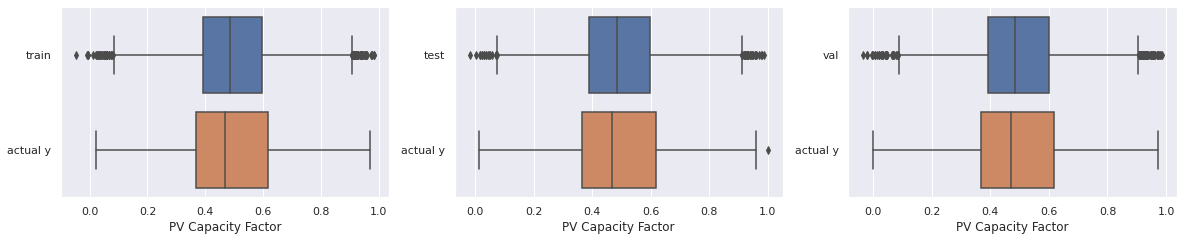

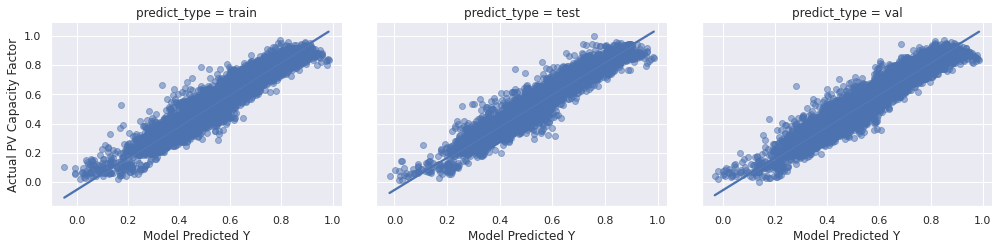

In [58]:
smodel1_6 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_6.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_6 = smodel1_6.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_6,shistory1_6,'Solar Model 6 - Multilayer DNN with Batch Normalization and Dropout History ','SModel1_6','solar','solar_model6')

## DNN Model 6.2 - Multilayer Model with Batch Normalization and Dropout and Adam

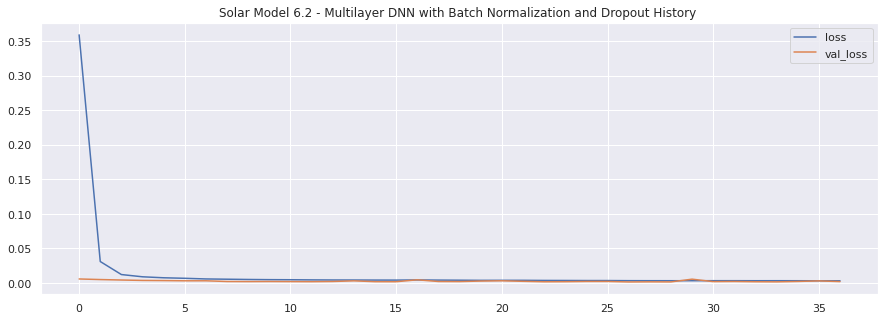

617/617 [==============================] - 1s 2ms/step
sSodel1_6_2 train outcome has 0.00137 MSE and the predicted data has 97.79& correlation at 0.0 p-level with the actual data.
sSodel1_6_2 test outcome has 0.00147 MSE and the predicted data has 97.68& correlation at 0.0 p-level with the actual data.
sSodel1_6_2 val outcome has 0.00146 MSE and the predicted data has 97.65& correlation at 0.0 p-level with the actual data.


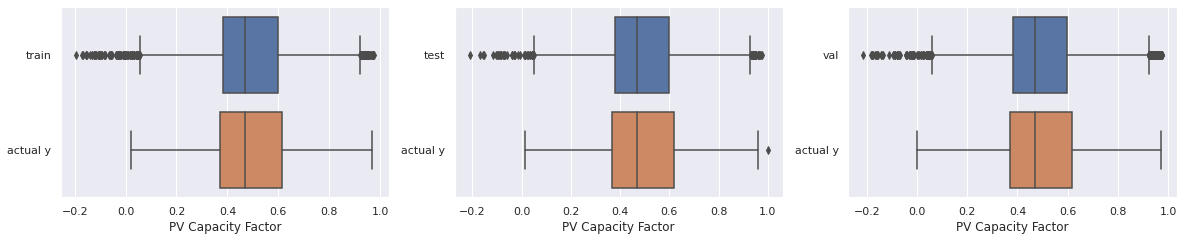

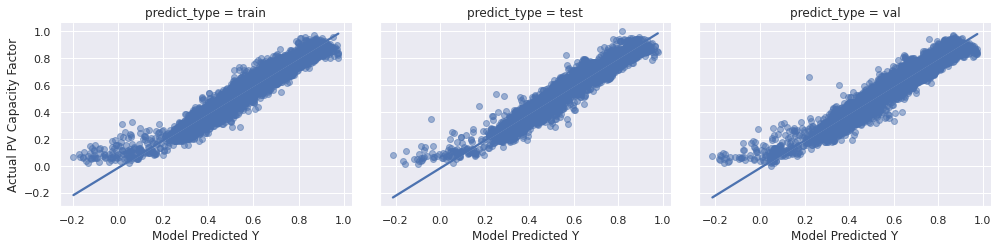

In [94]:
smodel1_6_2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_6_2.compile(loss="mean_squared_error", optimizer="adam")

shistory1_6_2 = smodel1_6_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_6_2,shistory1_6_2,'Solar Model 6.2 - Multilayer DNN with Batch Normalization and Dropout History ','sSodel1_6_2','solar','solar_model6_2')

## DNN Model 7 - Multilayer Model with Batch Normalization and Higher Dropout and Lower LR

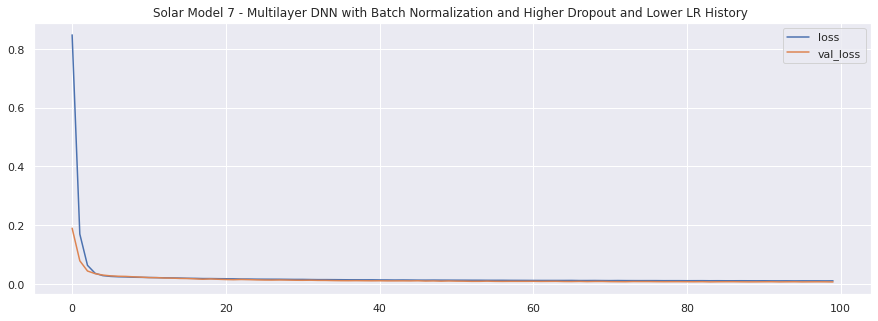

617/617 [==============================] - 1s 2ms/step
SModel1_7 train outcome has 0.00738 MSE and the predicted data has 90.97& correlation at 0.0 p-level with the actual data.
SModel1_7 test outcome has 0.00734 MSE and the predicted data has 90.97& correlation at 0.0 p-level with the actual data.
SModel1_7 val outcome has 0.00729 MSE and the predicted data has 90.9& correlation at 0.0 p-level with the actual data.


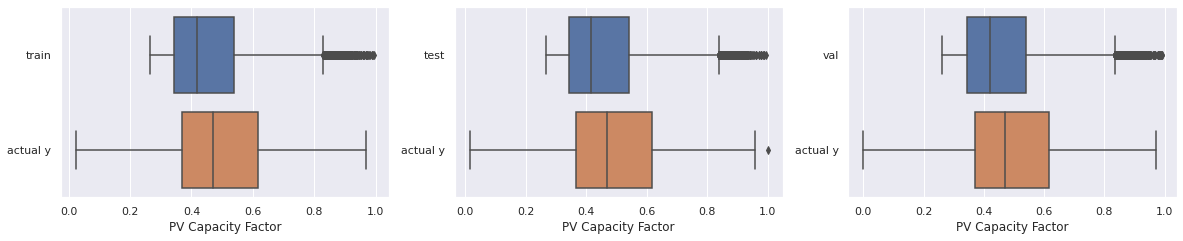

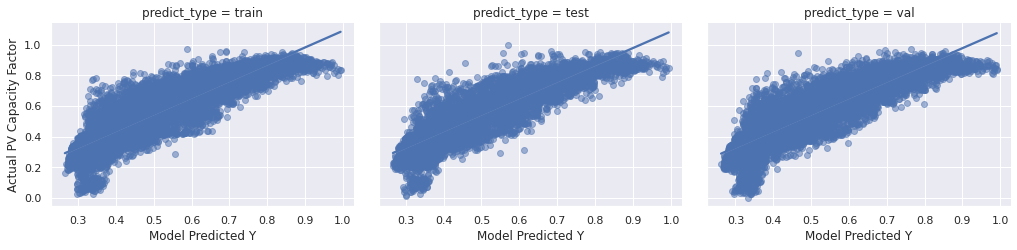

In [59]:
smodel1_7 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(250, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_7.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))

shistory1_7 = smodel1_7.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_7,shistory1_7,'Solar Model 7 - Multilayer DNN with Batch Normalization and Higher Dropout and Lower LR History ','SModel1_7','solar','solar_model7')

## DNN Model 8 - Multilayer Model with Dropout

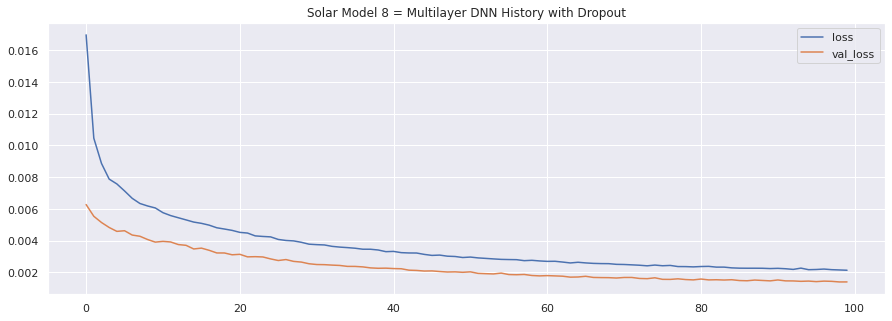

617/617 [==============================] - 1s 2ms/step
SModel1_8 train outcome has 0.00136 MSE and the predicted data has 97.82& correlation at 0.0 p-level with the actual data.
SModel1_8 test outcome has 0.00146 MSE and the predicted data has 97.69& correlation at 0.0 p-level with the actual data.
SModel1_8 val outcome has 0.00139 MSE and the predicted data has 97.75& correlation at 0.0 p-level with the actual data.


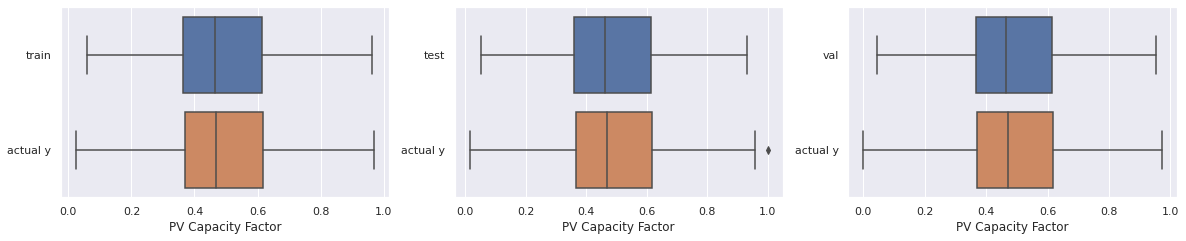

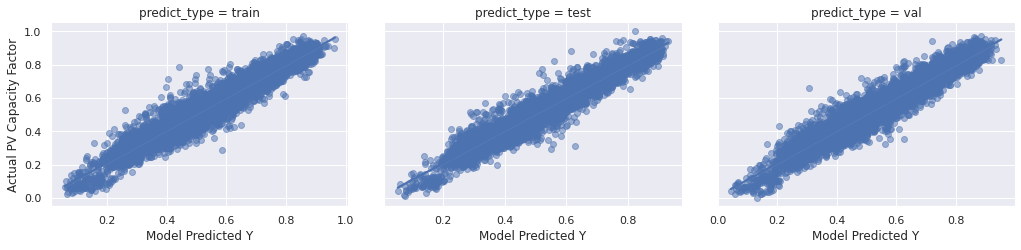

In [61]:
smodel1_8 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(1)
     ])
smodel1_8.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_8 = smodel1_8.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_8,shistory1_8,'Solar Model 8 = Multilayer DNN History with Dropout','SModel1_8','solar','solar_model8')

## DNN Model 8.2 - Multilayer Model with Dropout and ADAM

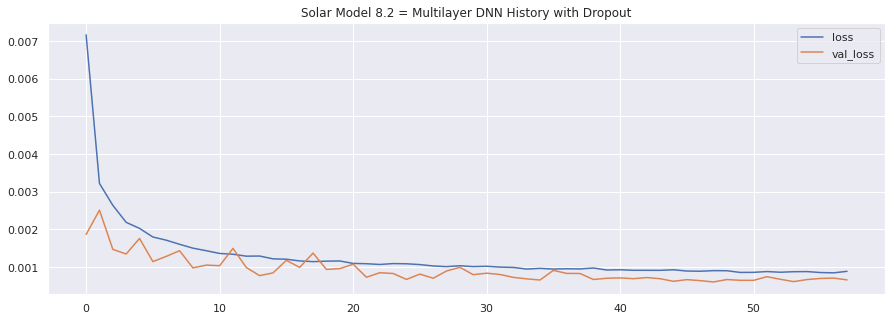

617/617 [==============================] - 1s 2ms/step
SModel1_8_2 train outcome has 0.00055 MSE and the predicted data has 99.12& correlation at 0.0 p-level with the actual data.
SModel1_8_2 test outcome has 0.00063 MSE and the predicted data has 99.0& correlation at 0.0 p-level with the actual data.
SModel1_8_2 val outcome has 0.00061 MSE and the predicted data has 99.03& correlation at 0.0 p-level with the actual data.


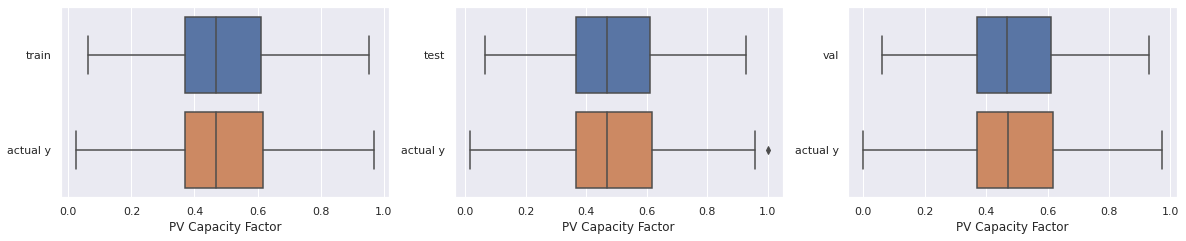

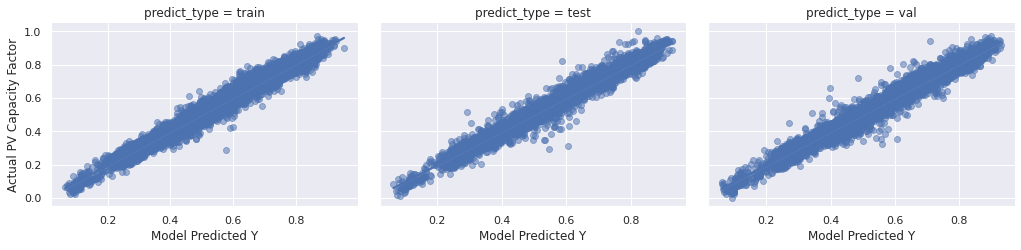

In [95]:
smodel1_8_2 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(1)
     ])
smodel1_8_2.compile(loss="mean_squared_error", optimizer="adam")

shistory1_8_2 = smodel1_8_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_8_2,shistory1_8_2,'Solar Model 8.2 = Multilayer DNN History with Dropout','SModel1_8_2','solar','solar_model8_2')

# Select Solar Model

In [143]:
# solar_models = [smodel1_1,smodel1_2,smodel1_3,smodel1_4,smodel1_4_2,smodel1_5,smodel1_5_2,smodel1_6,smodel1_6_2,smodel1_7,smodel1_8,smodel1_8_2]
# solar_histories = [history1_1,shistory1_2,shistory1_3,shistory1_4,shistory1_4_2,shistory1_5,shistory1_5_2,shistory1_6,shistory1_6_2,shistory1_7,shistory1_8,shistory1_8_2]
# solar_results = []
# for one,two in zip(solar_models,solar_histories):
#   solar_results.append(get_model_results1(one,two,'solar'))
# solar_r = pd.concat(solar_results)
# index_names = ['Solar Model 1',
#  'Solar Model 2',
#  'Solar Model 3',
#  'Solar Model 4',
#  'Solar Model 4.2',
#  'Solar Model 5',
#  'Solar Model 5.2',
#  'Solar Model 6',
#  'Solar Model 6.2',
#  'Solar Model 7',
#  'Solar Model 8',
#  'Solar Model 8.2']
solar_r_t = solar_r.copy().T
solar_r_t.columns = index_names
solar_results = solar_r_t.T
solar_results


,Train MSE,Train Corr,Test MSE,Test Corr,Validation MSE,Validation Corr,Train Loss Variance,Validation Loss Variance,Rate of Change in Train Loss,Rate of Change in Validation Loss
Solar Model 1,0.001369,97.79,0.001469,97.66,0.001395,97.73,4.107612e-06,1.285658e-06,-0.000182,-0.000056
Solar Model 2,0.001917,97.07,0.001993,96.99,0.001945,96.98,1.600086e-06,5.887546e-07,-0.000110,-0.000039
Solar Model 3,0.000883,98.57,0.000950,98.48,0.000921,98.50,1.418721e-05,5.212753e-07,-0.000462,-0.000065
Solar Model 4,0.001027,98.40,0.001100,98.30,0.001038,98.36,1.888572e-06,8.250094e-07,-0.000115,-0.000048
Solar Model 4.2,0.000392,99.39,0.000497,99.23,0.000482,99.23,2.797335e-07,7.482159e-08,-0.000056,-0.000012
Solar Model 5,0.001584,97.58,0.001660,97.50,0.001623,97.51,8.698864e-05,1.264628e-03,-0.001742,-0.006657
Solar Model 5.2,0.000637,99.01,0.000713,98.91,0.000686,98.93,3.299186e-05,1.867220e-06,-0.000785,-0.000137
Solar Model 6,0.002038,97.03,0.002183,96.87,0.002119,96.91,1.124925e-04,2.786257e-06,-0.001055,-0.000126
Solar Model 6.2,0.001375,97.79,0.001474,97.68,0.001460,97.65,3.406641e-03,1.263495e-06,-0.009620,-0.000103
Solar Model 7,0.007383,90.97,0.007344,90.97,0.007293,90.90,7.185205e-03,3.998449e-04,-0.008366,-0.001829


Between Model 3 and Model 4.2. Model 4.2 has the lowest validation across all prediction types and highest correlation, while Model 3 is also doing well, however Model 3 does better with the range of predictions for test and validation data compared to Model 4.2 which tends to be more conservative in predictions (looking at the boxplot).

I will do both Model 3 and Model 4.2.

# Run Model on the Rest of the Data

In [151]:
def get_model_results(bioclim_data,wind_or_solar,model,outcome_col_name):
  wind_x, wind_y, solar_x, solar_y, wind_df, solar_df = get_x_y(bioclim_data)
  scaler = MinMaxScaler()
  if wind_or_solar == 'solar':
    scaled_df = pd.DataFrame(scaler.fit_transform(solar_x.join(solar_y)))
    outcome_y = model.predict(scaled_df.iloc[:,:-1])
    reversed_result = pd.DataFrame(scaler.inverse_transform(scaled_df.iloc[:,:-1].join(pd.DataFrame(outcome_y).rename({0:outcome_col_name},axis=1))))
    to_map_result = solar_df.iloc[:,:13].dropna(axis=1).reset_index().join(reversed_result).rename({'index':'to_drop'},axis=1).drop('to_drop',axis=1)
    col_list = [i for i in solar_df.dropna(axis=1).columns]
    col_list.append('PV Capacity Factor')
    to_map_result.columns = col_list
  else:
    scaled_df = pd.DataFrame(scaler.fit_transform(wind_x.join(wind_y)))
    outcome_y = model.predict(scaled_df.iloc[:,:-1])
    reversed_result = pd.DataFrame(scaler.inverse_transform(scaled_df.iloc[:,:-1].join(pd.DataFrame(outcome_y).rename({0:outcome_col_name},axis=1))))
    to_map_result = wind_df.iloc[:,:13].dropna(axis=1).reset_index().join(reversed_result).rename({'index':'to_drop'},axis=1).drop('to_drop',axis=1)
    col_list = [i for i in wind_df.dropna(axis=1).columns]
    col_list.append('Wind Capacity Factor')
    to_map_result.columns = col_list
  return to_map_result


In [132]:
#make sure columns are in the same order as the normal df so the inputs are the same variables in succession
col_list = [i.lower() for i in normal.columns]
ssp2_10_40 = ssp2_10_40.rename({'tave-sm':'tave_sm'},axis=1)[col_list]
ssp2_41_70 = ssp2_41_70[col_list]
ssp5_10_40 = ssp5_10_40[col_list]
ssp5_41_70 = ssp5_41_70.rename({'pptsp':'ppt_sp','tavesm':'tave_sm','taveat':'tave_at'},axis=1)[col_list]

In [135]:
df_names = ['ssp2_10_40','ssp2_41_70','ssp5_10_40','ssp5_41_70','normal']
outcome_dfs = [ssp2_10_40,ssp2_41_70,ssp5_10_40,ssp5_41_70,normal]
results_1 = {}
for df_name,df in zip(df_names,outcome_dfs):
  results_1[df_name] = get_model_results(df,'solar',smodel1_3,f'{df_name}_model3_outcome')
  results_1[df_name].to_csv(f'{df_name}_model3_outcome.csv')
results_2 = {}
for df_name,df in zip(df_names,outcome_dfs):
  results_2[df_name] = get_model_results(df,'solar',smodel1_4_2,f'{df_name}_model4_2_outcome')
  results_2[df_name].to_csv(f'{df_name}_model4_2_outcome.csv')


1644/1644 [==============================] - 3s 2ms/step


# Plot Results

In [ ]:
def plot_density(df, y, radius, saveas, zoom, color_range):
    fig = px.density_mapbox(df, lat='latitude',lon='longitude',z=y,radius=3.8,zoom=zoom,color_continuous_scale='thermal',range_color=color_range)
    fig.update_layout(
            geo_scope='usa',
        )
    fig.update_layout(mapbox_style="white-bg",
                      mapbox=dict(center=go.layout.mapbox.Center(lat=38.8283, lon=-95.5795)))

    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.write_image(f'{saveas}_map.png', width=950, height=450)

    # fig.show()
#Used this locally because kaleido wouldn't work
for file in os.listdir(os.getcwd()+'/outcomes'):
    df = pd.read_csv(os.getcwd()+'/outcomes/'+file)
    plot_density(df,'PV Capacity Factor', 3.8, f'{file}_map',3.2, [0.1,0.3])

# Wind Version

In [157]:
X_train, X_test, y_train, y_test, X_val, y_val = prep_data(scaled_dataframes[0], 'wind')

## DNN Model 1

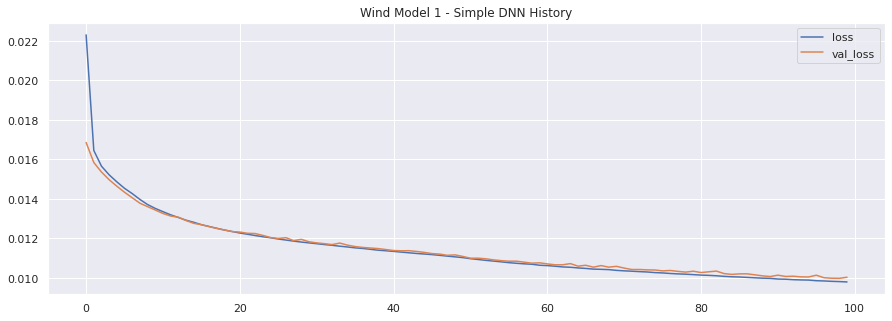

641/641 [==============================] - 1s 1ms/step
WModel1_1 train outcome has 0.00987 MSE and the predicted data has 81.6& correlation at 0.0 p-level with the actual data.
WModel1_1 test outcome has 0.00994 MSE and the predicted data has 81.31& correlation at 0.0 p-level with the actual data.
WModel1_1 val outcome has 0.01003 MSE and the predicted data has 80.54& correlation at 0.0 p-level with the actual data.


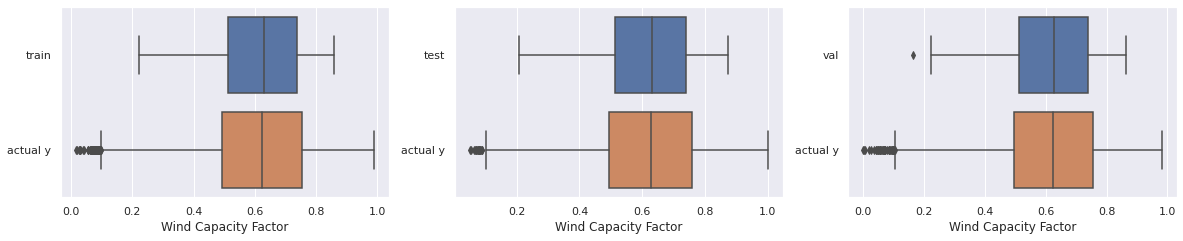

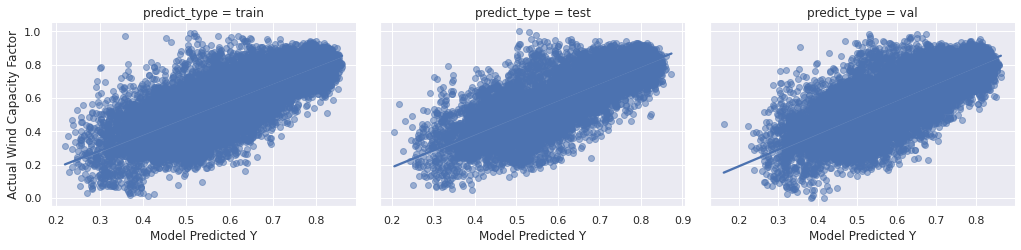

In [106]:
wmodel1_1 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(1)
     ])
wmodel1_1.compile(loss="mean_squared_error", optimizer="sgd")

whistory1_1 = wmodel1_1.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_1,whistory1_1,'Wind Model 1 - Simple DNN History','WModel1_1','wind','wind_model1')

## DNN Model 2

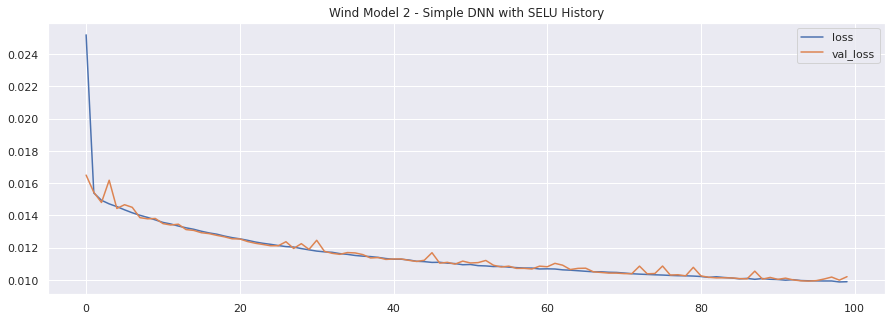

641/641 [==============================] - 1s 1ms/step
WModel1_2 train outcome has 0.01 MSE and the predicted data has 81.77& correlation at 0.0 p-level with the actual data.
WModel1_2 test outcome has 0.01018 MSE and the predicted data has 81.38& correlation at 0.0 p-level with the actual data.
WModel1_2 val outcome has 0.01021 MSE and the predicted data has 80.71& correlation at 0.0 p-level with the actual data.


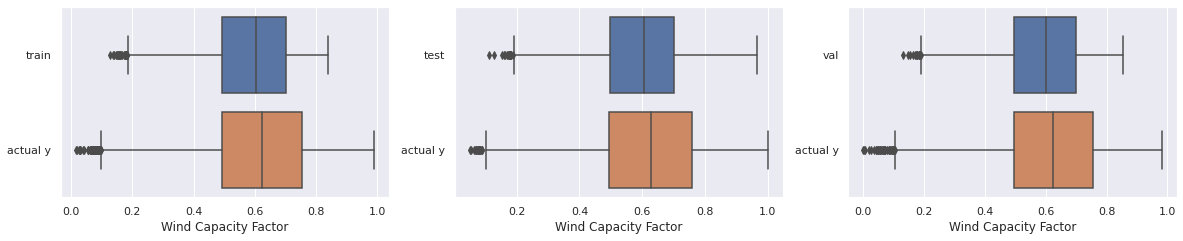

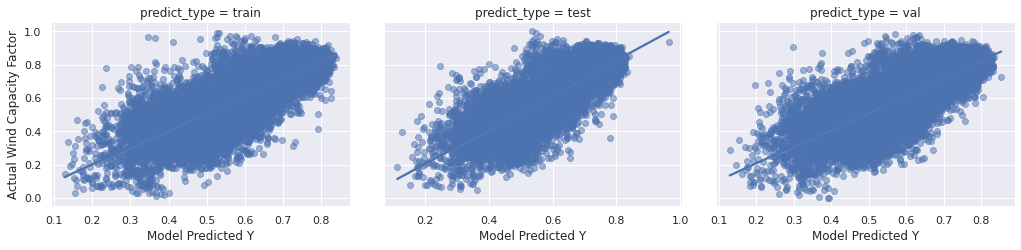

In [107]:
initializer = tf.keras.initializers.LecunNormal()

wmodel1_2 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="selu", input_shape=X_train.shape[1:],kernel_initializer=initializer),
         tf.keras.layers.Dense(1)
     ])
wmodel1_2.compile(loss="mean_squared_error", optimizer="sgd")

whistory1_2 = wmodel1_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_2,whistory1_2,'Wind Model 2 - Simple DNN with SELU History','WModel1_2','wind','wind_model2')

## DNN Model 3

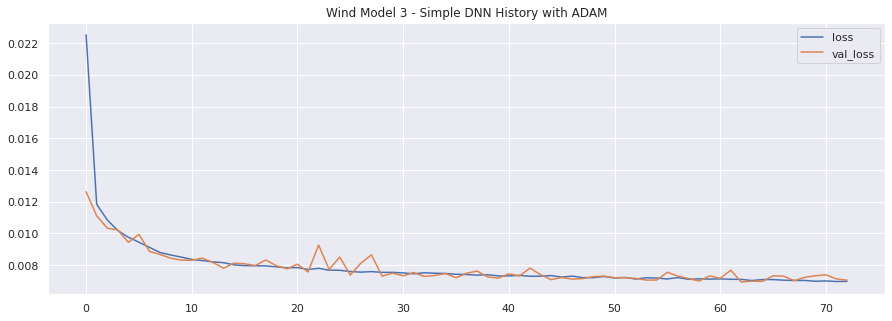

641/641 [==============================] - 1s 1ms/step
WModel1_3 train outcome has 0.00678 MSE and the predicted data has 87.6& correlation at 0.0 p-level with the actual data.
WModel1_3 test outcome has 0.00709 MSE and the predicted data has 86.93& correlation at 0.0 p-level with the actual data.
WModel1_3 val outcome has 0.00694 MSE and the predicted data has 86.86& correlation at 0.0 p-level with the actual data.


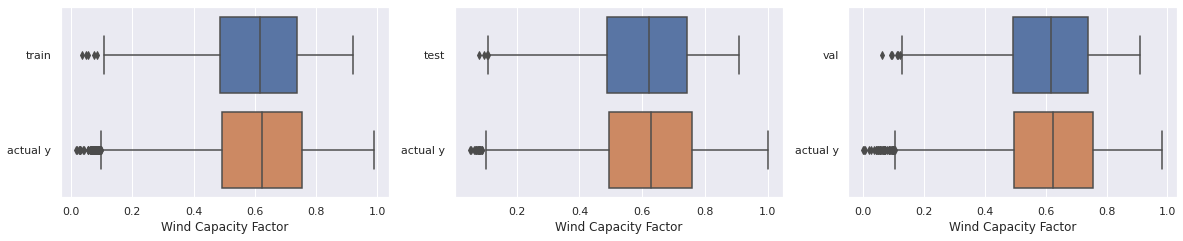

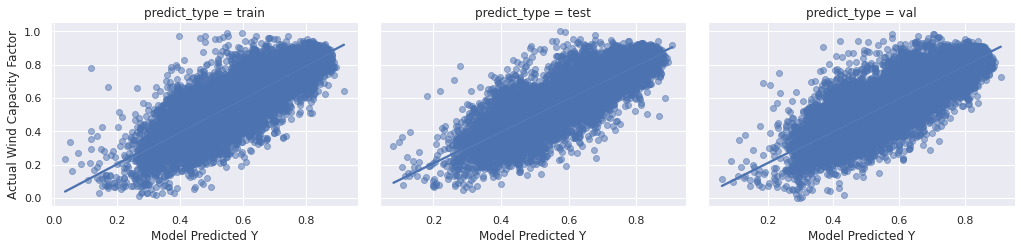

In [108]:
wmodel1_3 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(1)
     ])
wmodel1_3.compile(loss="mean_squared_error", optimizer="adam")

whistory1_3 = wmodel1_3.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_3,whistory1_3,'Wind Model 3 - Simple DNN History with ADAM','WModel1_3','wind','wind_model3')

## DNN Model 4

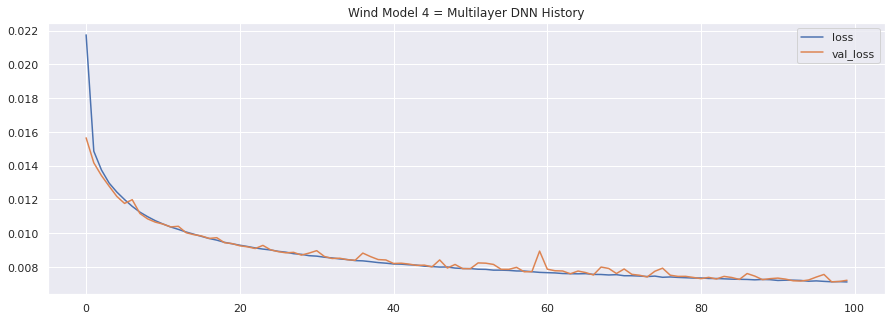

641/641 [==============================] - 1s 2ms/step
WModel1_4 train outcome has 0.00705 MSE and the predicted data has 87.27& correlation at 0.0 p-level with the actual data.
WModel1_4 test outcome has 0.00724 MSE and the predicted data has 86.79& correlation at 0.0 p-level with the actual data.
WModel1_4 val outcome has 0.0072 MSE and the predicted data has 86.46& correlation at 0.0 p-level with the actual data.


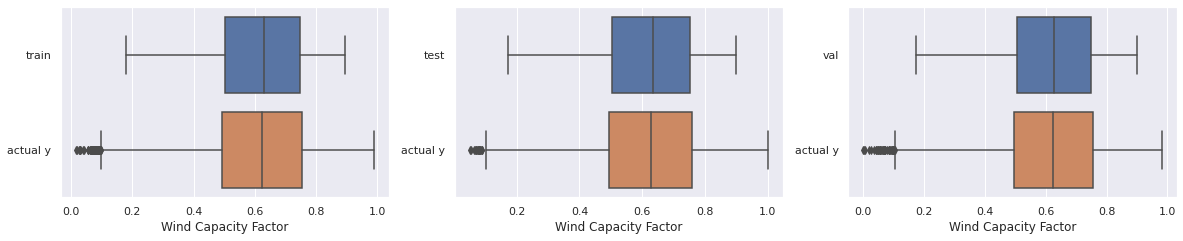

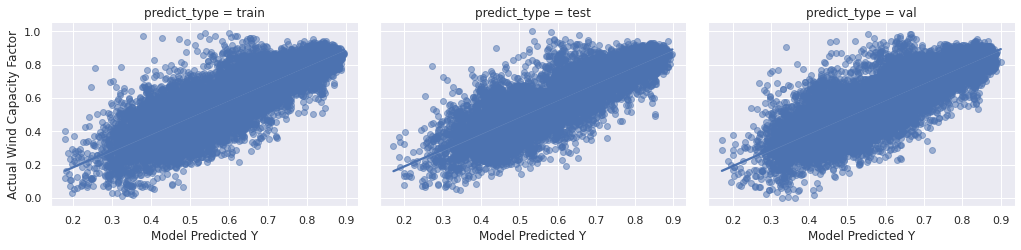

In [109]:
wmodel1_4 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dense(1)
     ])
wmodel1_4.compile(loss="mean_squared_error", optimizer="sgd")

whistory1_4 = wmodel1_4.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_4,whistory1_4,'Wind Model 4 = Multilayer DNN History','WModel1_4','wind','wind_model4')

## DNN Model 4.2

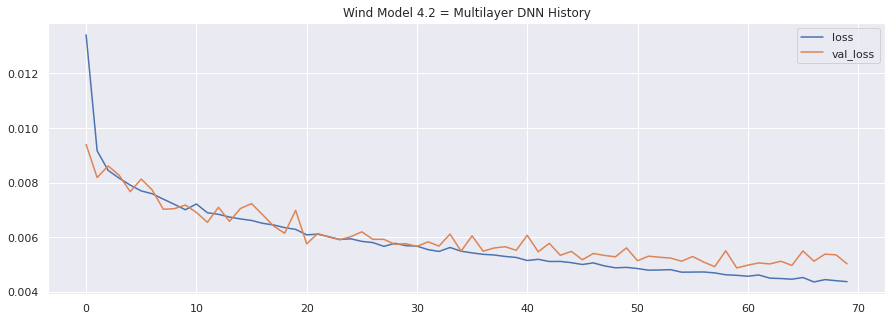

641/641 [==============================] - 1s 2ms/step
WModel1_4_2 train outcome has 0.00413 MSE and the predicted data has 92.67& correlation at 0.0 p-level with the actual data.
WModel1_4_2 test outcome has 0.00505 MSE and the predicted data has 90.91& correlation at 0.0 p-level with the actual data.
WModel1_4_2 val outcome has 0.00487 MSE and the predicted data has 91.01& correlation at 0.0 p-level with the actual data.


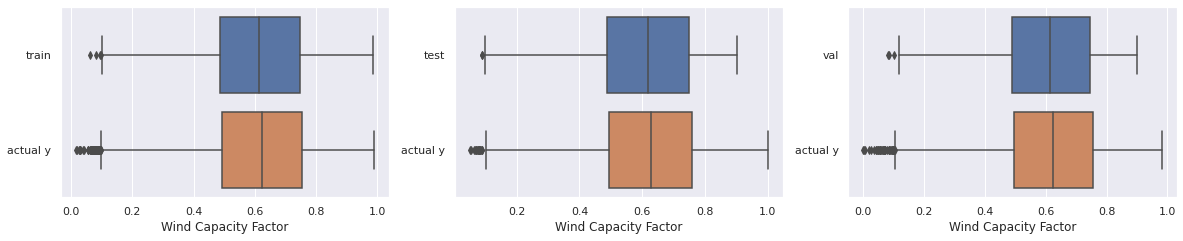

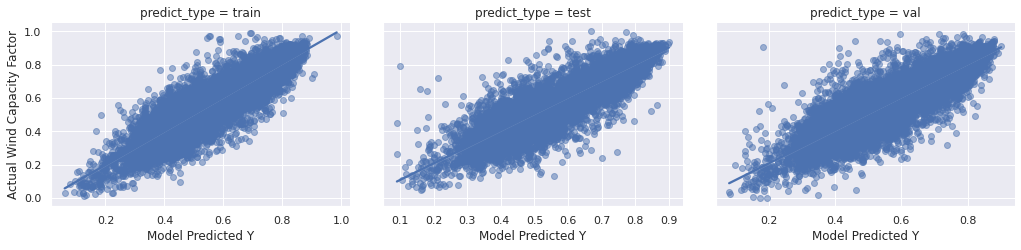

In [110]:
wmodel1_4_2 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dense(1)
     ])
wmodel1_4_2.compile(loss="mean_squared_error", optimizer="adam")

whistory1_4_2 = wmodel1_4_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_4_2,whistory1_4_2,'Wind Model 4.2 = Multilayer DNN History','WModel1_4_2','wind','wind_model4_2')

## DNN Model 4.3

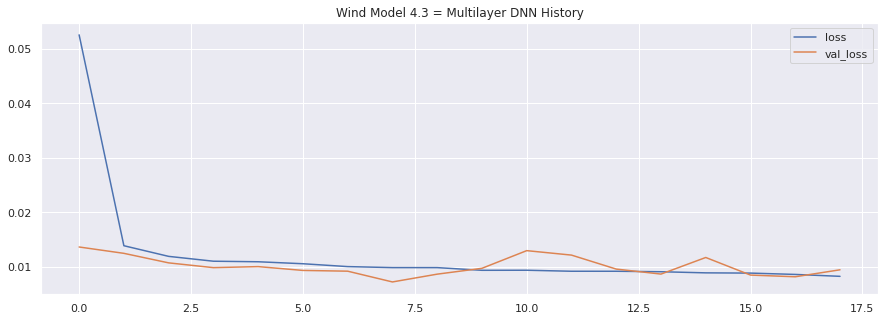

641/641 [==============================] - 1s 2ms/step
WModel1_4_3 train outcome has 0.00694 MSE and the predicted data has 87.44& correlation at 0.0 p-level with the actual data.
WModel1_4_3 test outcome has 0.00722 MSE and the predicted data has 86.87& correlation at 0.0 p-level with the actual data.
WModel1_4_3 val outcome has 0.0072 MSE and the predicted data has 86.55& correlation at 0.0 p-level with the actual data.


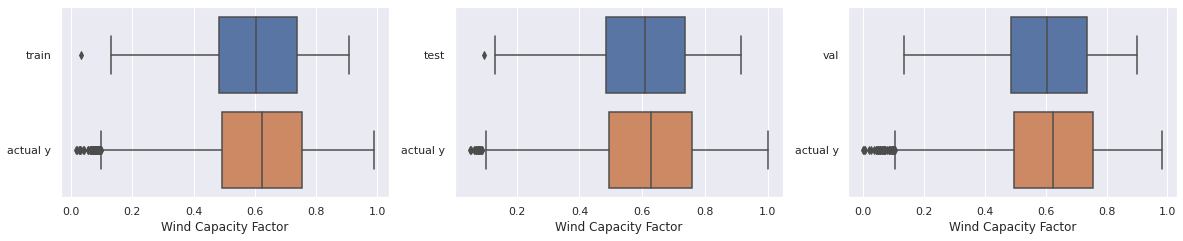

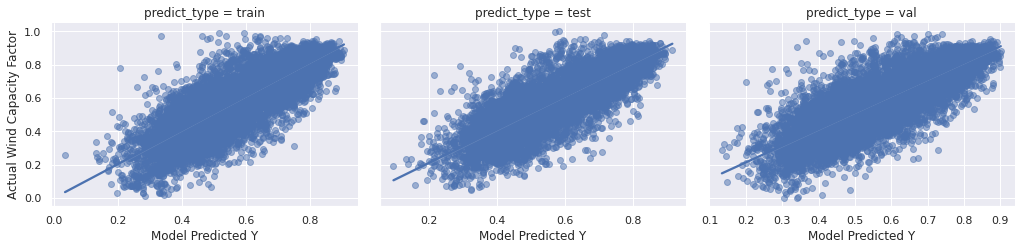

In [163]:
wmodel1_4_3 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.BatchNormalization(),   
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.BatchNormalization(),   
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.BatchNormalization(),   
         tf.keras.layers.Dense(1)
     ])
wmodel1_4_3.compile(loss="mean_squared_error", optimizer="adam")

whistory1_4_3 = wmodel1_4_3.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_4_3,whistory1_4_3,'Wind Model 4.3 = Multilayer DNN History','WModel1_4_3','wind','wind_model4_3')

## DNN Model 5

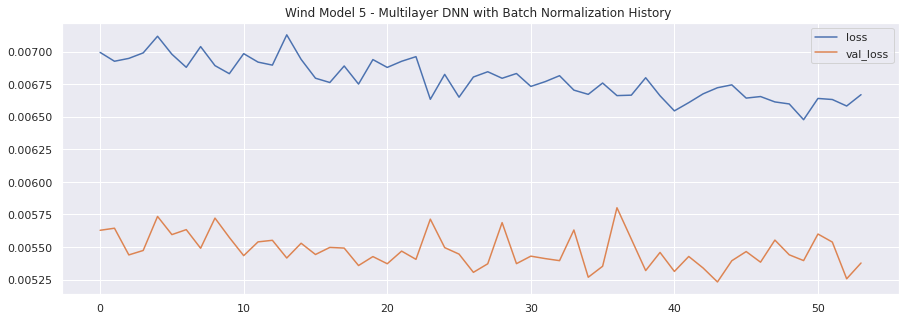

641/641 [==============================] - 1s 2ms/step
WModel1_5 train outcome has 0.0047 MSE and the predicted data has 91.63& correlation at 0.0 p-level with the actual data.
WModel1_5 test outcome has 0.00538 MSE and the predicted data has 90.27& correlation at 0.0 p-level with the actual data.
WModel1_5 val outcome has 0.00523 MSE and the predicted data has 90.3& correlation at 0.0 p-level with the actual data.


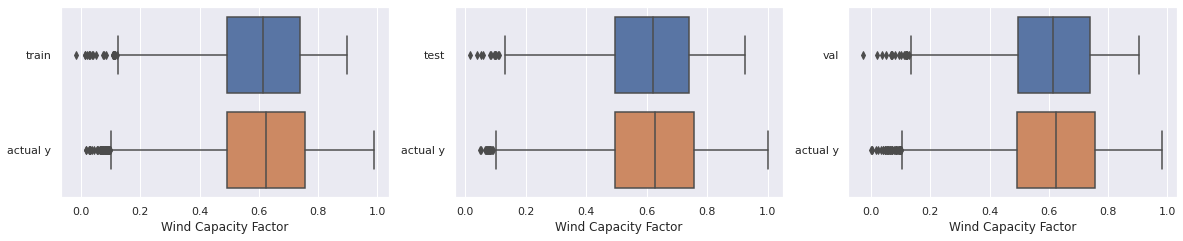

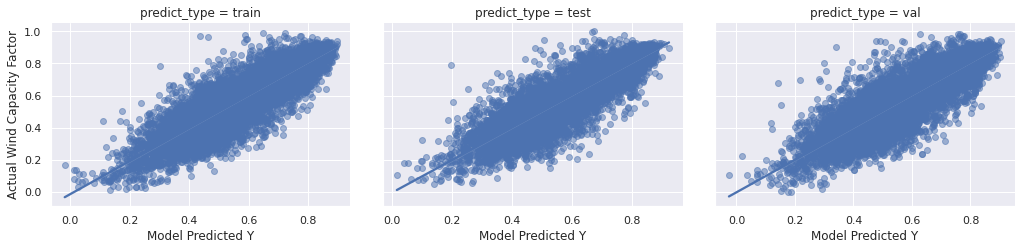

In [112]:
wmodel1_5 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
wmodel1_5.compile(loss="mean_squared_error", optimizer="sgd")

whistory1_5 = wmodel1_5.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_5,whistory1_5,'Wind Model 5 - Multilayer DNN with Batch Normalization History ','WModel1_5','wind','wind_model5')

## DNN Model 6

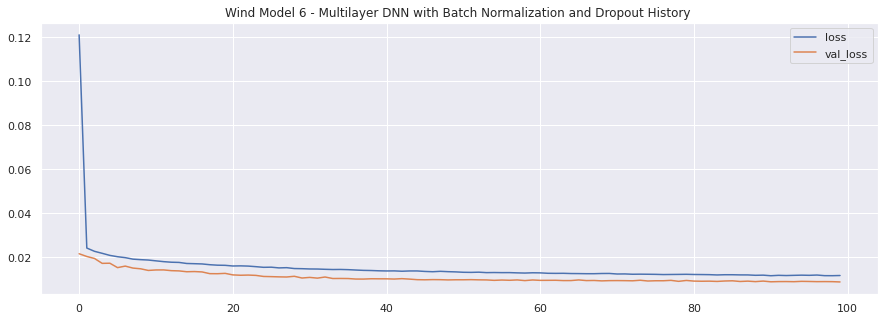

641/641 [==============================] - 2s 3ms/step
WModel1_6 train outcome has 0.0088 MSE and the predicted data has 83.63& correlation at 0.0 p-level with the actual data.
WModel1_6 test outcome has 0.00882 MSE and the predicted data has 83.49& correlation at 0.0 p-level with the actual data.
WModel1_6 val outcome has 0.00888 MSE and the predicted data has 82.86& correlation at 0.0 p-level with the actual data.


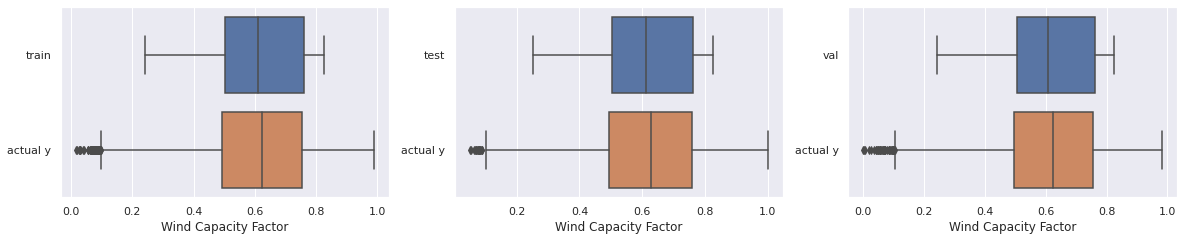

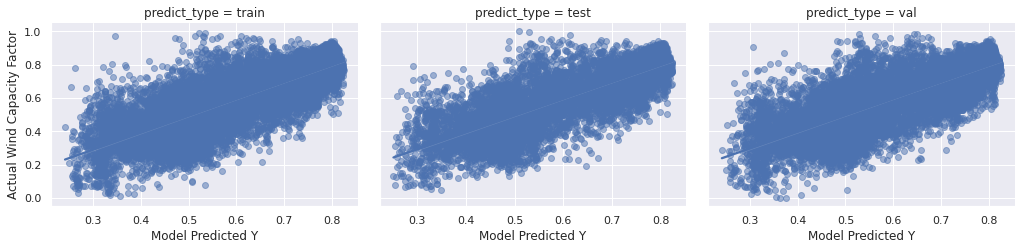

In [138]:
wmodel1_6 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
wmodel1_6.compile(loss="mean_squared_error", optimizer="sgd")

whistory1_6 = wmodel1_6.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_6,whistory1_6,'Wind Model 6 - Multilayer DNN with Batch Normalization and Dropout History ','WModel1_6','wind','wind_model6')

## DNN Model 6.2

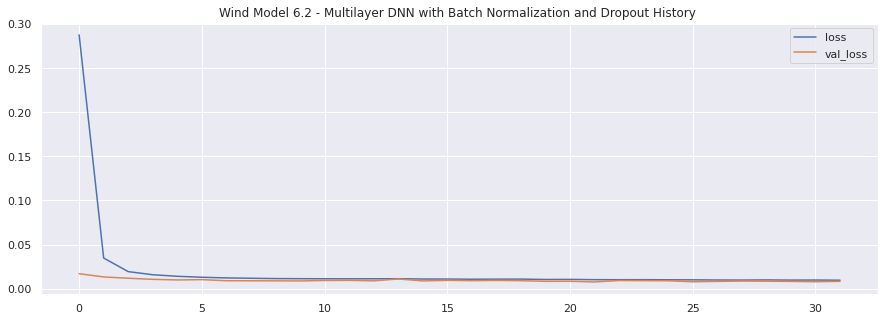

641/641 [==============================] - 2s 3ms/step
Wind1_6_2 train outcome has 0.00763 MSE and the predicted data has 85.98& correlation at 0.0 p-level with the actual data.
Wind1_6_2 test outcome has 0.00775 MSE and the predicted data has 85.69& correlation at 0.0 p-level with the actual data.
Wind1_6_2 val outcome has 0.00772 MSE and the predicted data has 85.35& correlation at 0.0 p-level with the actual data.


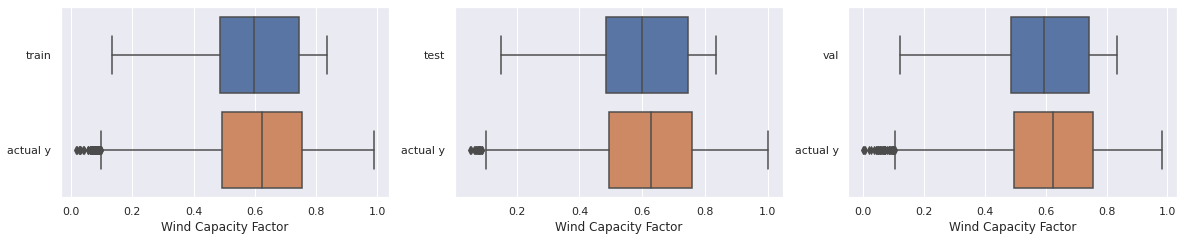

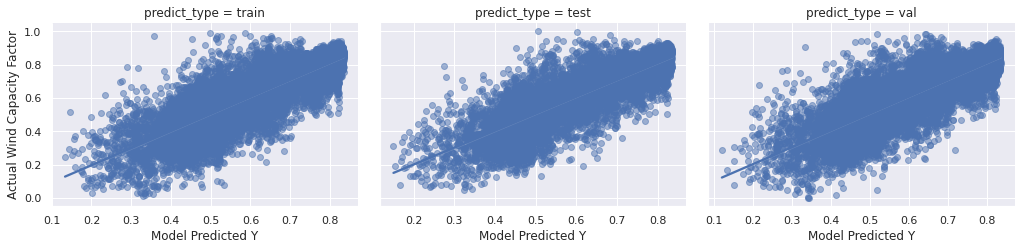

In [139]:
wmodel1_6_2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
wmodel1_6_2.compile(loss="mean_squared_error", optimizer="adam")

whistory1_6_2 = wmodel1_6_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_6_2,whistory1_6_2,'Wind Model 6.2 - Multilayer DNN with Batch Normalization and Dropout History ','Wind1_6_2','wind','wind_model6_2')

## DNN Model 7

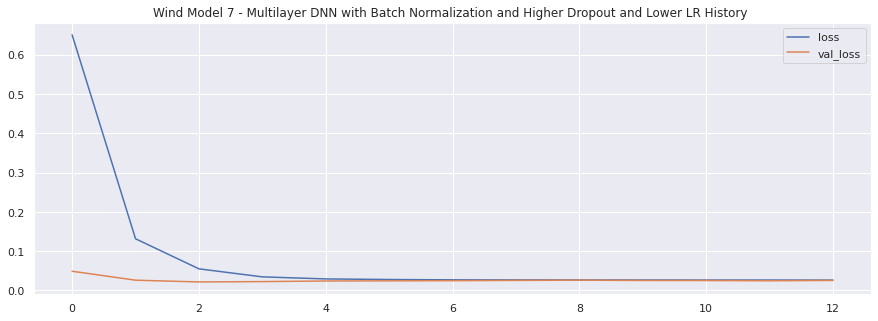

641/641 [==============================] - 2s 3ms/step
WModel1_7 train outcome has 0.02213 MSE and the predicted data has 58.58& correlation at 0.0 p-level with the actual data.
WModel1_7 test outcome has 0.02202 MSE and the predicted data has 58.68& correlation at 0.0 p-level with the actual data.
WModel1_7 val outcome has 0.02159 MSE and the predicted data has 57.56& correlation at 0.0 p-level with the actual data.


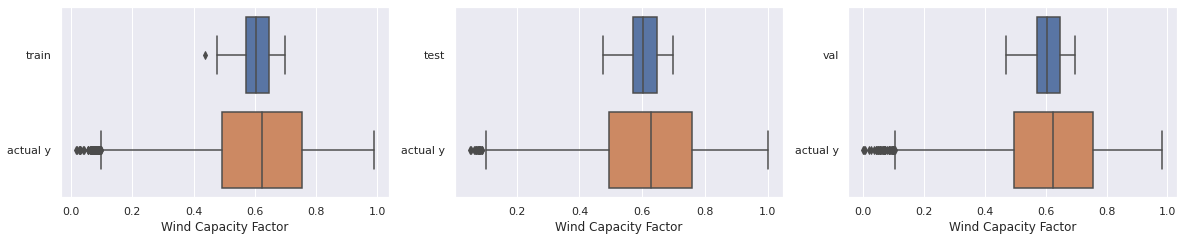

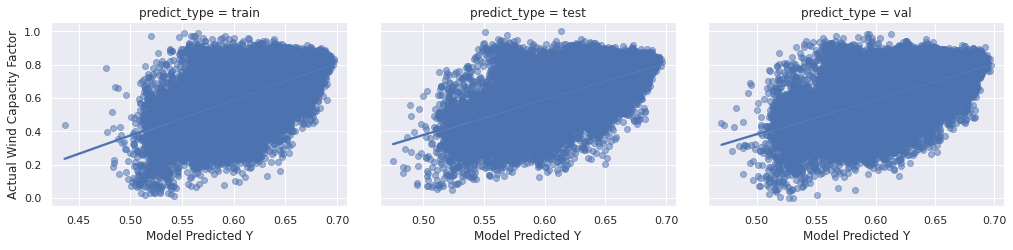

In [140]:
wmodel1_7 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(250, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
wmodel1_7.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))

whistory1_7 = wmodel1_7.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_7,whistory1_7,'Wind Model 7 - Multilayer DNN with Batch Normalization and Higher Dropout and Lower LR History ','WModel1_7','wind','wind_model7')

## DNN Model 8

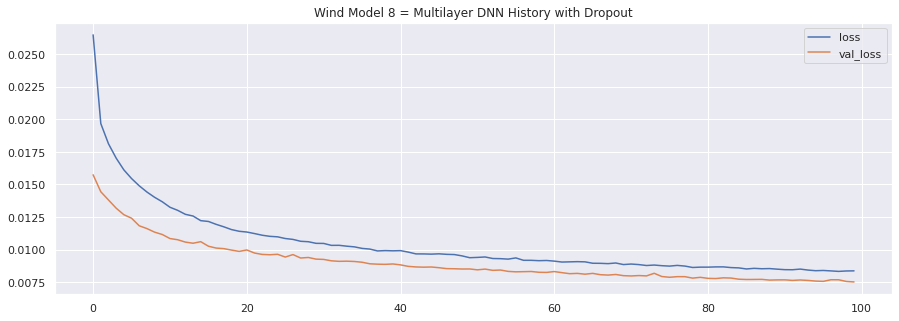

641/641 [==============================] - 1s 2ms/step
WModel1_8 train outcome has 0.00739 MSE and the predicted data has 86.39& correlation at 0.0 p-level with the actual data.
WModel1_8 test outcome has 0.00749 MSE and the predicted data has 86.12& correlation at 0.0 p-level with the actual data.
WModel1_8 val outcome has 0.00752 MSE and the predicted data has 85.67& correlation at 0.0 p-level with the actual data.


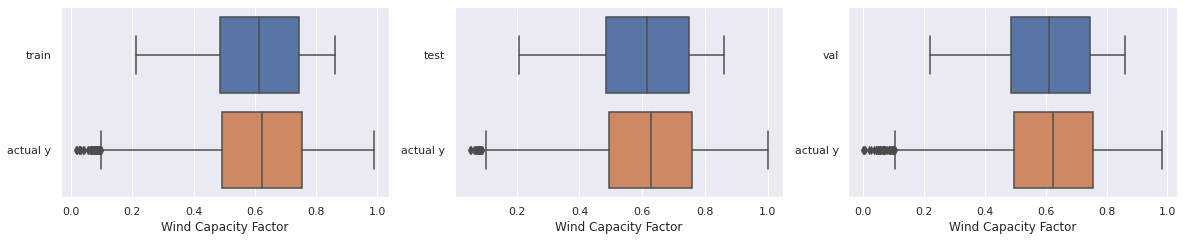

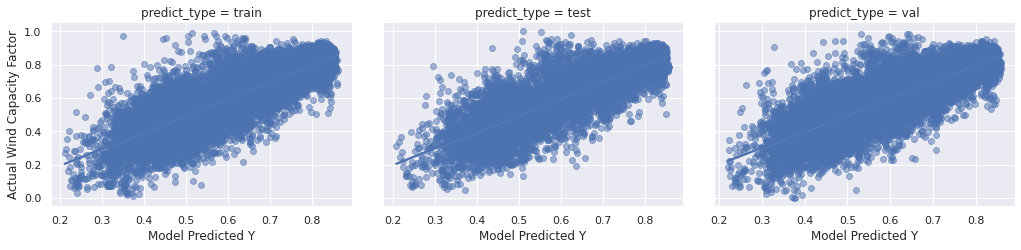

In [141]:
wmodel1_8 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(1)
     ])
wmodel1_8.compile(loss="mean_squared_error", optimizer="sgd")

whistory1_8 = wmodel1_8.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_8,whistory1_8,'Wind Model 8 = Multilayer DNN History with Dropout','WModel1_8','wind','wind_model8')

## DNN Model 8.2

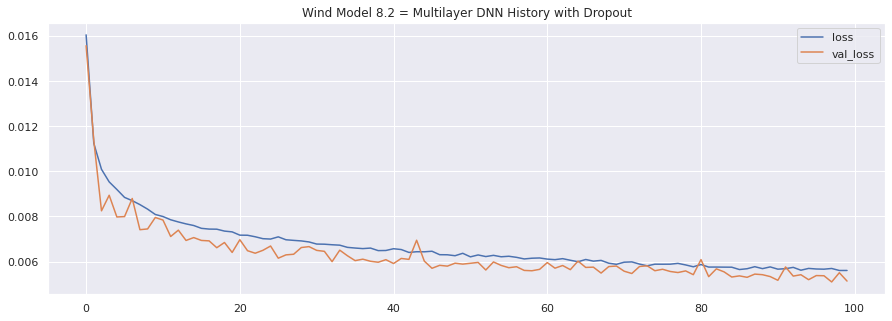

641/641 [==============================] - 1s 2ms/step
WModel1_8_2 train outcome has 0.00462 MSE and the predicted data has 91.78& correlation at 0.0 p-level with the actual data.
WModel1_8_2 test outcome has 0.00534 MSE and the predicted data has 90.37& correlation at 0.0 p-level with the actual data.
WModel1_8_2 val outcome has 0.00514 MSE and the predicted data has 90.48& correlation at 0.0 p-level with the actual data.


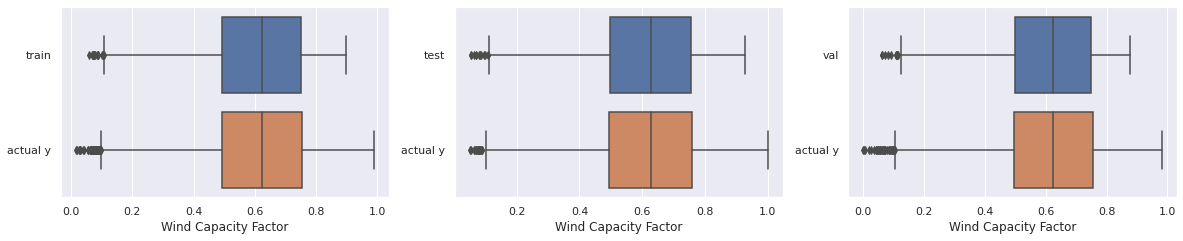

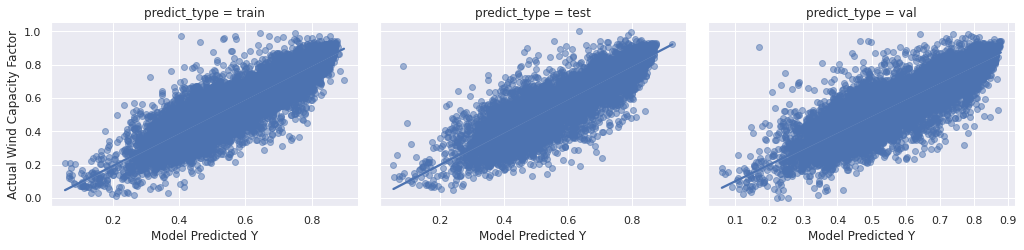

In [142]:
wmodel1_8_2 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(1)
     ])
wmodel1_8_2.compile(loss="mean_squared_error", optimizer="adam")

whistory1_8_2 = wmodel1_8_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(wmodel1_8_2,whistory1_8_2,'Wind Model 8.2 = Multilayer DNN History with Dropout','WModel1_8_2','wind','wind_model8_2')

# Select Model

In [165]:
wind_models = [wmodel1_1,wmodel1_2,wmodel1_3,wmodel1_4,wmodel1_4_2,wmodel1_4_3,wmodel1_5,wmodel1_6,wmodel1_6_2,wmodel1_7,wmodel1_8,wmodel1_8_2]
wind_histories = [whistory1_1,whistory1_2,whistory1_3,whistory1_4,whistory1_4_2,whistory1_4_3,whistory1_5,whistory1_6,whistory1_6_2,whistory1_7,shistory1_8,shistory1_8_2]
wind_results = []
for one,two in zip(wind_models,wind_histories):
  wind_results.append(get_model_results1(one,two,'wind'))
wind_r = pd.concat(wind_results)
index_names = ['Wind Model 1',
 'Wind Model 2',
 'Wind Model 3',
 'Wind Model 4',
 'Wind Model 4.2',
 'Wind Model 4.3',
 'Wind Model 5',
 'Wind Model 6',
 'Wind Model 6.2',
 'Wind Model 7',
 'Wind Model 8',
 'Wind Model 8.2']
wind_r_t = wind_r.copy().T
wind_r_t.columns = index_names
wind_results = wind_r_t.T
wind_results


641/641 [==============================] - 1s 2ms/step


,Train MSE,Train Corr,Test MSE,Test Corr,Validation MSE,Validation Corr,Train Loss Variance,Validation Loss Variance,Rate of Change in Train Loss,Rate of Change in Validation Loss
Wind Model 1,0.009870,81.60,0.009941,81.31,0.010030,80.54,3.185091e-06,1.975141e-06,-0.000125,-0.000068
Wind Model 2,0.009998,81.77,0.010177,81.38,0.010207,80.71,3.732327e-06,2.124273e-06,-0.000153,-0.000063
Wind Model 3,0.006776,87.60,0.007091,86.93,0.006944,86.86,3.805936e-06,1.048980e-06,-0.000213,-0.000076
Wind Model 4,0.007053,87.27,0.007236,86.79,0.007204,86.46,4.071469e-06,2.541545e-06,-0.000147,-0.000084
Wind Model 4.2,0.004128,92.67,0.005048,90.91,0.004870,91.01,2.083969e-06,9.945630e-07,-0.000129,-0.000063
Wind Model 4.3,0.006942,87.44,0.007218,86.87,0.007203,86.55,1.027428e-04,3.208680e-06,-0.002461,-0.000232
Wind Model 5,0.004698,91.63,0.005381,90.27,0.005232,90.30,2.248528e-08,1.663179e-08,-0.000006,-0.000005
Wind Model 6,0.008801,83.63,0.008818,83.49,0.008878,82.86,1.209747e-04,6.663892e-06,-0.001092,-0.000128
Wind Model 6.2,0.007635,85.98,0.007749,85.69,0.007725,85.35,2.387663e-03,3.239119e-06,-0.008676,-0.000269
Wind Model 7,0.022132,58.58,0.022019,58.68,0.021592,57.56,2.963284e-02,4.675151e-05,-0.048010,-0.001795


It seems like the best one is Model 4.2 due to low train, test, val loss and low validation loss variance.

# Run Model on the rest of the data

In [162]:
df_names = ['ssp2_10_40','ssp2_41_70','ssp5_10_40','ssp5_41_70','normal']
outcome_dfs = [ssp2_10_40,ssp2_41_70,ssp5_10_40,ssp5_41_70,normal]
results_1 = {}
for df_name,df in zip(df_names,outcome_dfs):
  results_1[df_name] = get_model_results(df,'wind',wmodel1_4_2,f'wind_{df_name}_model4_2_outcome')
  results_1[df_name].to_csv(f'wind_{df_name}_model4_2_outcome.csv')



1709/1709 [==============================] - 4s 2ms/step
